In [1]:
import os
import ogs6py
import vtuIO
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import time

# Radionuclides migration in Opalinus clay

The diffusion of Cs-135 and U-238 through a 1-D column of fully water-saturated Opalinus clay for 1 million years is simulated using a mechanistic approach via the coupling of OGS to PHREEQC (OGS#iPHREEQC). Radioactive decay has not been considered due to the long half-lives (Nagra, 2002) of Cs-135 (2.3e6 years) and U-238 (4.5e9 years). The diffusion of radionuclides into the clay porewater is modeled with a Dirichlet boundary condition applied at the left side of the domain, whereas the right-side is modeled as a closed boundary (Neumann). The 1-D domain length is 40 m, which is sufficient to ensure that Cs does not reach the right-side boundary.

The following Opalinus clay properties are used:

| Parameter | Value | Unit |
| :-: | :-: | :-: |
| Porosity $\phi$ | 0.15 | - |
| Pore diffusion coefficient $\mathrm{D_p}$ | 1e-10 | m$^2$/s |
| Effective diffusion coefficient $\mathrm{D_e}$ | 1.5-11 | m$^2$/s |
| Pressure $P$ |1 | atm |
| Temperature $T$ | 25 | C |

The domain is discretized in 200 linear elements (avg. element size = 0.2 m) with a non-uniform mesh refinement at the inlet boundary (to account for the high concentration gradient produced due to the constant concentration). The minimum and maximum element sizes are 0.04 m and 0.35 m, respectively (element length multiplier = 1.00625). Mesh-independence has been verified by running the simulations with a mesh with 400 elements (0.1 m element size). The results did not show a significant difference. The temporal discretization follows the maximum time-step size given by the von Neumann stability critetion for diffusive transport:

$$
\Delta t < \frac{{\Delta x}^2}{2 D_p},
$$

therefore, a uniform time-stepping scheme is adopted with $\Delta t = \text{2e8}~s~(\approx 6.34~\text{years})$. This means that the simulation needs a total of 157680 time-steps to estimate the migration of 1 million years. This causes that large CPU times are needed when using OGS#iPHREEQC.

Finally, the total concentrations in Opalinus clay of the main species, including background concentrations of Cs and U, are as follows:

| Species (mol/kgw) | Value |
| :-: | :-: |
| HCO$_3^-$ |  4.659 $\times$ 10$^{-4}$ |
| Ca$^{2+}$ |  2.651 $\times$ 10$^{-2}$   |
| Cl$^-$ |  3.058 $\times$ 10$^{-1}$ |
| K$^+$ |  1.631 $\times$ 10$^{-3}$ |
| Mg$^{2+}$ |  1.733 $\times$ 10$^{-2}$ |
| Na$^+$ |  2.447 $\times$ 10$^{-1}$ |
| SO$_4^{2-}$ |  1.417 $\times$ 10$^{-2}$ |
| Sr$^{2+}$ |  4.577 $\times$ 10$^{-4}$ |
| Cs$^+$ |  1.019 $\times$ 10$^{-10}$ |
| U$_\text{total}$ |  2.549 $\times$ 10$^{-9}$ |
| pH | 7.6 |
| pE | -2  |

## Cs-135 migration

A Cs concentration at the left boundary of 1.019e-7 mol/kgw is set constant throughout the simulation. The sorption model is taken from Águila et al., 2021. Cs-135 migration is simulated by using OGS#iPHREEQC via the `<surface>` keyword with the following parameters: 

| Site name | Description | Capacity (mol/kgw) |
| :-: | :-: | :-: |
| Su\_ | Double layer planar sites | 1.425 |
| Su\_ii | Type II sites of intermediate strength | 1.38e-1 |
| Su\_fes | Frayed edge sites | 1.8e-3 |

The corresponding reactions of the sorption model are added to the latest version (2020) of the PSI/Nagra thermodynamic database (`PSINagra2020v1-1_davies.dat`). 

In the `Cs.prj` file, the surface input under the `<chemical_system>` keyword is:
```XML
<chemical_system chemical_solver="Phreeqc">
    ...
        <surface site_unit="mole">
            <site>
                <name>Su_</name>
            </site>
            <site>
                <name>Su_fes</name>
            </site>
            <site>
                <name>Su_ii</name>
            </site>
        </surface>
    ...
```

The amounts of each site are given through the `<media>` keyword as follows:
```XML
                <phase>
                    <type>Solid</type>
                    <components>
                        <component>
                            <name>Su_</name>
                            <properties>
                                <property>
                                    <name>molality</name>
                                    <type>Constant</type>
                                    <value>1.4250e+00</value>
                                </property>
                            </properties>
                        </component>
                        <component>
                            <name>Su_fes</name>
                            <properties>
                                <property>
                                    <name>molality</name>
                                    <type>Constant</type>
                                    <value>1.8000e-03</value>
                                </property>
                            </properties>
                        </component>
                        <component>
                            <name>Su_ii</name>
                            <properties>
                                <property>
                                    <name>molality</name>
                                    <type>Constant</type>
                                    <value>1.3800e-01</value>
                                </property>
                            </properties>
                        </component>
                    </components>
                </phase>
```

Where the site names should be an exact match in both `<media>` and `<chemical_system>` keywords. This means that it is possible to setup complex simulations comprised of multiple physical domains with distinct chemical systems (e.g., different sorption sites, diffusion, porosity) such as the multiple barriers in a nuclear waste repository. 

### 1) Solve the numerical model

The simulation takes approximately 23 hrs. to complete when t = 1e6 years. Therefore, only the first 50 time-steps are simulated in this notebook. To run the full simulation, the time loop parameters can be easily adapted.

In [2]:
out_dir = os.environ.get('OGS_TESTRUNNER_OUT_DIR', '_out')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

prj_name = "Cs.prj"

t0 = time.time()
print(">>> OGS started execution ... <<<")

! ogs {prj_name} -o {out_dir} > {out_dir}/outCs.txt

tf = time.time()
print(">>> OGS terminated execution  <<< Elapsed time: ", round(tf - t0, 2), " s.")

>>> OGS started execution ... <<<
>>> OGS terminated execution  <<< Elapsed time:  15.98  s.


### 2) Plot the results

Results can be conveniently visualized with <a href="https://github.com/joergbuchwald/VTUinterface">VTUinterface</a>. Note that the results of the full simulation are plotted (provided in the folder `./Cs_full_simulation`). The results of the first 50 time steps can be plotted by replacing `pvdfile` with the commented line below. 

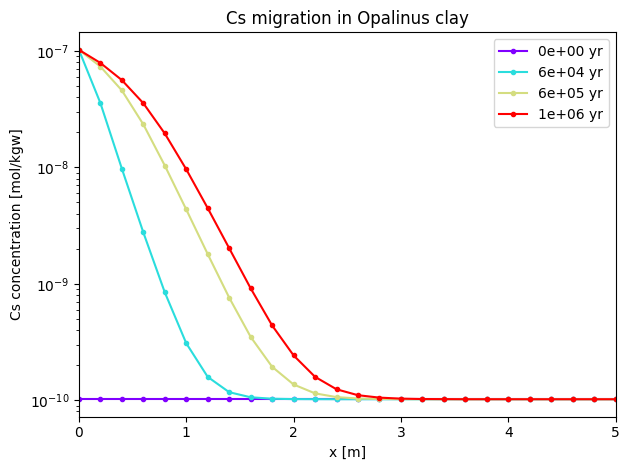

In [12]:
length = 40
xaxis = [(i, 0, 0) for i in np.linspace(start=0.0, stop=length, num=201)]
x = np.array(xaxis)[:, 0]
fieldname = "Cs"

#Read simulation results
pvdfile = vtuIO.PVDIO("./Cs_full_simulation/out.pvd", dim=1)
# pvdfile = vtuIO.PVDIO(f"{out_dir}/Cs.pvd", dim=1)

color_map=iter(cm.rainbow(np.linspace(0,1,len(pvdfile.timesteps))))

#Plot the results
fig, ax = plt.subplots()

for t, c in zip(pvdfile.timesteps, color_map):
    y = pvdfile.read_set_data(t, fieldname, pointsetarray=xaxis)
    ax.plot(x, y, color=c, marker='.', label="{:.0e} yr".format(round(t/3600/24/365, 0)))

ax.set_xlim(0,5)
ax.set_title("Cs migration in Opalinus clay")
ax.set_ylabel("Cs concentration [mol/kgw]")
ax.set_xlabel("x [m]")
ax.set_yscale('log')
ax.legend()
plt.tight_layout()

The results show that Cs-135 does not migrate for more than 3 m even after 1 million years.

## U-238 migration

Similarly, a U concentration at the left boundary of 1.060e-6 mol/kgw is applied to the domain. In this case, the sorption model is taken from Hennig et al., 2020. U-238 migration is simulated by using OGS#iPHREEQC via the `<surface>` keyword definition with the following parameters: 

| Site name | Description | Capacity (mol/kgw) |
| :-: | :-: | :-: |
| Ill\_wOH | Illite weak site | 6.254e-1 |
| Ill\_sOH | Illite strong site | 1.384e-2 |
| Kln\_aOH | Kaolinite Aluminol site | 7.351e-2 |
| Kln\_siOH | Kaolinite Silanol site | 7.351e-2 |
| Mll\_wOH | Montmorillonite weak site | 1.137e-1 |
| Mll\_sOH | Montmorillonite strong site | 2.516e-3 |
| ChlOH | Chlorite | 9.414e-3 |

The Opalinus clay parameters remain the same as in the Cs case, as well as the space-time discretization. In the same way, the reactions of the sorption model are added to the themodynamic database `PSINagra2020v1-1_davies.dat`. 

### 1) Solve the numerical model

The model is solved for the first 50 time steps only to minimize the CPU time of this notebook. The time loop parameters in `U.prj` can be adapted accordingly to cover the full simulation time of 1 million years. 

In [9]:
prj_name = "U.prj"

t0 = time.time()
print(">>> OGS started execution ... <<<")

! ogs {prj_name} -o {out_dir} > {out_dir}/outU.txt

tf = time.time()
print(">>> OGS terminated execution  <<< Elapsed time: ", round(tf - t0, 2), " s.")

>>> OGS started execution ... <<<
>>> OGS terminated execution  <<< Elapsed time:  25.5  s.


### 2) Plot the results

Again, the full simulation results are provided in `/U_full_simulation`. They are plotted to show the migration of U after 1 million years.

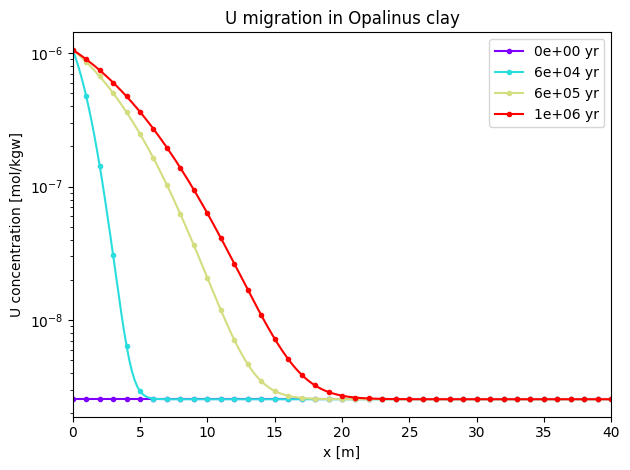

In [13]:
length = 40
xaxis = [(i, 0, 0) for i in np.linspace(start=0.0, stop=length, num=201)]
x = np.array(xaxis)[:, 0]
fieldname = "U"

#Read simulation results
pvdfile = vtuIO.PVDIO("./U_full_simulation/out.pvd", dim=1)
# pvdfile = vtuIO.PVDIO(f"{out_dir}/U.pvd", dim=1)

color_map=iter(cm.rainbow(np.linspace(0,1,len(pvdfile.timesteps))))

#Plot the results
fig, ax = plt.subplots()

for t, c in zip(pvdfile.timesteps, color_map):
    y = pvdfile.read_set_data(t, fieldname, pointsetarray=xaxis)
    ax.plot(x, y, color=c, marker=".", markevery=5, label="{:.0e} yr".format(round(t/3600/24/365, 0)))

ax.set_xlim(0,40)
ax.set_title("U migration in Opalinus clay")
ax.set_ylabel("U concentration [mol/kgw]")
ax.set_xlabel("x [m]")
ax.set_yscale('log')
ax.legend()
plt.tight_layout()

In this case, it is clear that the migration of U-238 is much more pronounced than Cs-135. After 1 million years, U-238 shows a breakthrough to around 20 m. 

## References

Águila, J. F., Montoya, V., Samper, J., Montenegro, L., Kosakowski, G., Krejci, P., & Pfingsten, W. (2021). Modeling cesium migration through Opalinus clay: a benchmark for single-and multi-species sorption-diffusion models. Computational Geosciences, 25(4), 1405-1436.

Garibay-Rodriguez, J., Chen, C., Shao, H., Bilke, L., Kolditz, O., Montoya, V., & Lu, R. (2022). Computational framework for radionuclide migration assessment in clay rocks. Frontiers in Nuclear Engineering (under review).

Hennig, T., Stockmann, M., & Kühn, M. (2020). Simulation of diffusive uranium transport and sorption processes in the Opalinus Clay. Applied Geochemistry, 123, 104777.

Hummel W. Thoenen T. (2021): The PSI Chemical Thermodynamic Database 2020, Nagra NTB 21-03.

<a href="https://web.archive.org/web/20220314123055/https://backend.nagra.ch/system/files/attachments/ntb/ntb2002/e_ntb02-006.pdf">Nagra, 2002.</a> Project Opalinus Clay: Models, Codes and Data for Safety Assessment. Technical Report NTB 02–06. Nagra, Switzerland.

**Credits:**

Jaime Garibay-Rodriguez, Chaofan Chen, Haibing Shao, Lars Bilke, Olaf Kolditz,
Vanessa Montoya, Renchao Lu